# Incorporating uncertainty

In this tutorial, we show how to quickly set up and train a CNN-based regression model including uncertainty with the deep4cast package. The goal is to highlight how adding uncertainty allows the addition of bounds on predictions. The example data constitutes of a monthly 26-dimensional multivariate time series.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
from deep4cast.metrics import adjust_for_horizon, mape, mase, msis, coverage
from pandas import read_table

%matplotlib inline

/Users/shirleyren/Development/deep4cast/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data preparation

Before we can fit a model we first have to load, clean, and prepare our dataset so that the model can accept it.

In [2]:
# Load the data from file
filename = 'timeseries_data.csv'
df = read_table(filename, sep=',')

In [3]:
# Set lookback window for truncated sample time series
lag = 20 # i.e. 20 months
test_fraction = 0.15
test_length = int(len(df) * test_fraction)
train_length = len(df) - test_length

# Prepare train and test set
ts = df.astype('float32').values
ts = np.expand_dims(ts, axis=-1)
ts_train = ts[:-test_length]
ts_test = ts[-test_length - lag:]

### Plot of the time series data

Text(0.5,1,'Black: training time series; Red: testing time series')

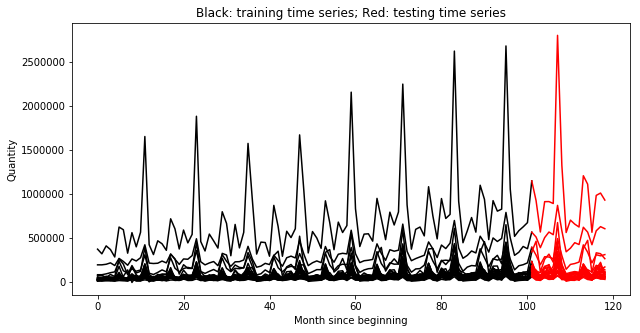

In [4]:
plt.figure(figsize=(10,5))
plt.plot(ts[:train_length,:,0], 'k')
plt.plot(range(len(ts[:train_length-1,:,0]), len(ts)), ts[train_length-1:,:,0], 'r')
plt.xlabel('Month since beginning')
plt.ylabel('Quantity')
plt.title('Black: training time series; Red: testing time series')

## Utility functions to evaluate prediction accuracy and uncertainty

In [5]:
metric_list = ['mape', 'mase']
metric_names = {'mape':'Mean Absolute Percentage Error', 'mase':'Mean Absolute Scaled Error'}

def criticize_model_mean_accuracy(forecaster, metric_list, metric_names, freq = 12):
    ts_train_pred_mean = forecaster.predict(ts_train)['mean']
    ts_test_pred_mean = forecaster.predict(ts_test)['mean']
    
    for i in range(len(metric_list)):
        if (metric_list[i] == 'mape'):
            metric = adjust_for_horizon(mape)
            print('TRAIN \t {0}: {1:.1f}%'.format(metric_names[metric_list[i]], 
                                                  metric(ts_train_pred_mean, ts[lag:train_length])))
            print('TEST \t {0}: {1:.1f}%'.format(metric_names[metric_list[i]], 
                                                 metric(ts_test_pred_mean, ts[train_length:])))
        elif (metric_list[i] == 'mase'):
            metric = adjust_for_horizon(mase)
            print('TRAIN \t {0}: {1:.1f}%'.format(metric_names[metric_list[i]], 
                                                  metric(ts_train_pred_mean, ts[lag:train_length], ts_train, freq)))
            print('TEST \t {0}: {1:.1f}%'.format(metric_names[metric_list[i]], 
                                                 metric(ts_test_pred_mean, ts[train_length:], ts_train, freq)))

In [6]:
metric_list = ['msis', 'coverage']
metric_names = {'msis':'Mean Scaled Interval Score', 'coverage': 'Confidence Interval Coverage'}
freq = 12

def criticize_model_uncertainty(forecaster, metric_list, freq = 12, confidence_level = 0.95):
    alpha = 1.0 - confidence_level
    ts_train_pred = forecaster.predict(ts_train, n_samples = 1000, quantiles=(alpha/2*100, (1-alpha/2)*100))
    ts_test_pred = forecaster.predict(ts_test, n_samples = 1000, quantiles=(alpha/2*100, (1-alpha/2)*100))
        
    ts_train_pred_upper = ts_train_pred['upper_quantile']
    ts_train_pred_lower = ts_train_pred['lower_quantile']
    ts_test_pred_upper = ts_test_pred['upper_quantile']
    ts_test_pred_lower = ts_test_pred['lower_quantile']
    
    for i in range(len(metric_list)):
        if (metric_list[i] == 'msis'):
            metric = adjust_for_horizon(msis)
            print('TRAIN \t {0}: {1:.1f}%'.format(metric_names[metric_list[i]], 
                                                  metric(ts_train_pred_upper, ts_train_pred_lower, 
                                                         ts[lag:train_length], ts_train, freq, alpha)))
            print('TEST \t {0}: {1:.1f}%'.format(metric_names[metric_list[i]], 
                                                 metric(ts_test_pred_upper, ts_test_pred_lower, 
                                                        ts[train_length:], ts_train, freq, alpha)))
        elif (metric_list[i] == 'coverage'):
            metric = adjust_for_horizon(coverage)
            print('TRAIN \t {0}: {1:.1f}%'.format(metric_names[metric_list[i]], 
                                                  metric(ts_train_pred_upper, ts_train_pred_lower, 
                                                         ts[lag:train_length])))
            print('TEST \t {0}: {1:.1f}%'.format(metric_names[metric_list[i]], 
                                                 metric(ts_test_pred_upper, ts_test_pred_lower, 
                                                        ts[train_length:])))

### Understand the metric MASE (Mean Absoluate Scaled Error)

In [7]:
# check naive case of MASE = 0: perfect prediction
metric = adjust_for_horizon(mase)
print('TRAIN \t Mean Absolute Scaled Error: {0:.1f}%'.format(metric(ts[lag:train_length], ts[lag:train_length], ts_train, freq)))
print('TEST \t Mean Absolute Scaled Error: {0:.1f}%'.format(metric(ts[train_length:], ts[train_length:], ts_train, freq)))

TRAIN 	 Mean Absolute Scaled Error: 0.0%
TEST 	 Mean Absolute Scaled Error: 0.0%


In [8]:
# check naive case of MASE = 100%: prediction based on last year's observation.
metric = adjust_for_horizon(mase)
print('TRAIN \t Mean Absolute Scaled Error: {0:.1f}%'.format(metric(ts_train[:-freq], ts_train[freq:], ts_train, freq)))
print('TEST \t Mean Absolute Scaled Error: {0:.1f}%'.format(metric(ts_test[:-freq], ts_test[freq:], ts_train, freq)))

TRAIN 	 Mean Absolute Scaled Error: 100.0%
TEST 	 Mean Absolute Scaled Error: 98.2%


## Temporal Convolutional Neural Network Forecaster with Uncertainty

We choose the temporal CNN, which uses one-dimensional convolutions for modeling purposes.

In [ ]:
# Hyper-parameters
topology = [
    {
        'meta': {'layer_type': 'Conv1D', 'layer_id': 'c1', 'parent_ids': ['input']},
        'params': {'filters': 64, 'kernel_size': 5, 'activation': 'elu'}
    },
    {
        'meta': {'layer_type': 'Conv1D', 'layer_id': 'c2', 'parent_ids': ['c1']},
        'params': {'filters': 64, 'kernel_size': 3, 'activation': 'elu'}
    },
    {
        'meta': {'layer_type': 'Conv1D', 'layer_id': 'c3','parent_ids': ['c2']},
        'params': {'filters': 128, 'kernel_size': 3, 'activation': 'elu'}
    },
    {
        'meta': {'layer_type': 'Flatten', 'layer_id': 'f1', 'parent_ids': ['c3']},
        'params': {}
    },
    {
        'meta': {'layer_type': 'Dense', 'layer_id': 'd1', 'parent_ids': ['f1']
        },
        'params': {'units': 128, 'activation': 'elu'}
    },
    {
        'meta': {'layer_type': 'Dense', 'layer_id': 'd2', 'parent_ids': ['d1']},
        'params': {'units': 128, 'activation': 'elu'}
    }
]

# Instantiate regression model
forecaster = Forecaster(
    topology,
    optimizer='sgd',
    lag=lag,
    horizon=1,
    batch_size=8,
    epochs=2500,
    uncertainty=True,
    concreteDropout=True,
#    dropout_rate = 0.1,
    lr=0.1
)
forecaster.fit(ts_train)

### Plot of training loss over iterations

In [ ]:
# Plot training error history
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r') 
plt.xlabel('Epoch number')
plt.ylabel('Mean-squared training error')

### Performance of prediction accuracy

In [ ]:
metric_list = ['mape', 'mase']
metric_names = {'mape':'Mean Absolute Percentage Error', 'mase':'Mean Absolute Scaled Error'}
freq = 12
criticize_model_mean_accuracy(forecaster, metric_list, metric_names, freq)

### Performance of prediction uncertainty

In [ ]:
metric_list = ['msis', 'coverage']
metric_names = {'msis':'Mean Scaled Interval Score', 'coverage': 'Confidence Interval Coverage'}
freq = 12
criticize_model_uncertainty(forecaster, metric_list, freq, confidence_level = 0.95)

### Visualization of prediction with uncertainty

In [ ]:
ts_pred = forecaster.predict(ts_test, n_samples=100)
ts_pred_mean = ts_pred['mean']
ts_pred_median = ts_pred['median']
ts_pred_upper_quantile = ts_pred['upper_quantile']
ts_pred_lower_quantile = ts_pred['lower_quantile']
ts_pred_samples = ts_pred['samples']

Plot of prediction samples of test set including uncertainty bounds

In [ ]:
ncols = 5
fig, axes = plt.subplots(nrows=26//ncols+1, ncols=ncols, sharex=True, sharey=True, figsize=(12, 9))
for ax, ya, yp, yp_upper, yp_lower, title in zip(axes.flat, 
                                                 ts[train_length:,:,0].T, 
                                                 ts_pred_mean[:,:,0].T, 
                                                 ts_pred_upper_quantile[:,:,0].T, 
                                                 ts_pred_lower_quantile[:,:,0].T, 
                                                 range(1,26+1)):
    ax.plot(ya, 'k-')
    ax.plot(yp, 'g-')
    ax.plot(yp_lower, 'g:')
    ax.plot(yp_upper, 'g:')
    ax.set_title(title)

plt.tight_layout()